In [1]:
mse <- function(y, yhat) mean((y - yhat)^2)
#install.packages(c('glmnet','gglasso','genlasso','pls','Matrix','imager'))

In [2]:


# -------------------- LASSO via glmnet -----------------------------
# Uses glmnet and cv.glmnet to select lambda
lasso_glmnet <- function(X, y, nfolds = 5, alpha = 1) {
  if (!requireNamespace('glmnet', quietly = TRUE)) stop('Install package glmnet')
  library(glmnet)
  # glmnet expects x as matrix, y as vector
  cvfit <- cv.glmnet(x = X, y = y, alpha = alpha, nfolds = nfolds, standardize = TRUE)
  lambda_min <- cvfit$lambda.min
  coef_vec <- as.numeric(coef(cvfit, s = "lambda.min")) # includes intercept at index 1
  intercept <- coef_vec[1]
  beta <- coef_vec[-1]
  list(cvfit = cvfit, lambda_min = lambda_min, intercept = intercept, beta = beta,summary=summary(cvfit))
}

predict_lasso_glmnet <- function(fit, Xnew) {
  predict(fit$cvfit, newx = Xnew, s = "lambda.min")
}
# Generating data
Data_generation <- function(n = 200, p = 20, s = 7, sigma = 1, seed = 1) {
  set.seed(seed)
  # Sets the seed for random number generation. This ensures that if you run
  # the function with the same seed, you will get the exact same simulated data
  # each time.

  X <- matrix(rnorm(n * p), n, p)

  beta <- rep(0, p) #true beta

  beta[1:s] <- seq(from = 2, length.out = s, by = -0.3)
  # This means only the first 's' predictors in X will have a non-zero effect on y.

  y <- X %*% beta + rnorm(n, sd = sigma)
  # The error is added to the linear combination to get the final response 'y'.

  list(X = X, y = as.numeric(y), beta = beta)
  # Returns a list containing the generated data and the true coefficients:
  # X: the predictor matrix
  # y: the response vector (converted to a numeric vector using as.numeric)
  # beta: the true coefficient vector
}
L=Data_generation(n=50)
Scaled_X=scale(L$X, center = TRUE, scale = TRUE)
model_small=lasso_glmnet(X=Scaled_X,y=L$y)
mse_small=mse(L$y,predict_lasso_glmnet(model_small,Scaled_X))
L=Data_generation(n=250)
Scaled_X=scale(L$X, center = TRUE, scale = TRUE)
model_moderate=lasso_glmnet(X=Scaled_X,y=L$y)
mse_moderate=mse(L$y,predict_lasso_glmnet(model_moderate,Scaled_X))
L=Data_generation(n=1000)
Scaled_X=scale(L$X, center = TRUE, scale = TRUE)
model_large=lasso_glmnet(X=Scaled_X,y=L$y)
mse_large=mse(L$y,predict_lasso_glmnet(model_large,Scaled_X))

Loading required package: Matrix

Loaded glmnet 4.1-10



In [3]:
# -------------------- Utilities --------------------
mse <- function(y, yhat) mean((y - yhat)^2)

# -------------------- Grouped data generator --------------------
# n: samples, groups: integer vector or number of groups,
# group_size: scalar or vector specifying sizes for each group,
# n_active: number of groups that should be non-zero,
# coef_mag: magnitude for nonzero coefficients (can be scalar or function)
Data_generation_grouped <- function(n = 200,
                                    n_groups = 20,
                                    group_size = 3,
                                    n_active = 5,
                                    coef_mag = function(k) seq(from = 2, length.out = k, by = -0.3),
                                    sigma = 1,
                                    seed = 1) {
  set.seed(seed)
  # Build group sizes
  if (length(group_size) == 1) {
    group_size <- rep(group_size, n_groups)
  } else {
    if (length(group_size) != n_groups) stop("group_size length must equal n_groups")
  }
  p <- sum(group_size)
  # design matrix
  X <- matrix(rnorm(n * p), nrow = n, ncol = p)
  # groups vector: length p, values 1..n_groups
  groups <- rep(seq_len(n_groups), times = group_size)
  # true beta: group-sparse
  beta <- rep(0, p)
  active_groups <- sample(seq_len(n_groups), n_active)
  # assign coefficients within each active group
  for (g in active_groups) {
    idxs <- which(groups == g)
    k <- length(idxs)
    if (is.function(coef_mag)) {
      vals <- coef_mag(k)
      # if returned length differs, recycle/truncate
      vals <- rep(vals, length.out = k)
    } else if (length(coef_mag) == 1) {
      vals <- rep(coef_mag, k)
    } else {
      vals <- rep(coef_mag, length.out = k)
    }
    beta[idxs] <- vals
  }
  # response
  y <- as.numeric(X %*% beta + rnorm(n, sd = sigma))
  list(X = X, y = y, beta = beta, groups = groups, active_groups = active_groups)
}

# -------------------- Group LASSO via gglasso (robust) --------------------
group_lasso_gglasso <- function(X, y, groups, nfolds = 5) {
  if (!requireNamespace('gglasso', quietly = TRUE)) stop('Install package gglasso')
  library(gglasso)
  stopifnot(length(groups) == ncol(X))
  n <- nrow(X)
  # enforce sensible nfolds
  if (nfolds >= n) {
    nfolds <- max(2, n)  # set to n for LOOCV-like when appropriate
    message("Adjusted nfolds to ", nfolds)
  }
  # scale X and save scaling params
  x_scaled <- scale(X, center = TRUE, scale = TRUE)
  x_center <- attr(x_scaled, "scaled:center")
  x_scale  <- attr(x_scaled, "scaled:scale")
  cvfit <- cv.gglasso(x = x_scaled, y = y, group = groups, loss = "ls", nfolds = nfolds)
  lambda_min <- cvfit$lambda.min
  beta_full <- coef(cvfit, s = "lambda.min")
  intercept <- as.numeric(beta_full[1])
  beta <- as.numeric(beta_full[-1])
  y_hat <- as.numeric(predict(cvfit, x_scaled, s = "lambda.min"))
  list(cvfit = cvfit,
       lambda_min = lambda_min,
       intercept = intercept,
       beta = beta,
       x_center = x_center,
       x_scale = x_scale,
       x_scaled = x_scaled,
       mse = mse(y, y_hat))
}

# -------------------- Prediction helper --------------------
predict_group_gglasso <- function(res, X_new) {
  if (!is.null(res$x_center) && !is.null(res$x_scale)) {
    Xs <- scale(X_new, center = res$x_center, scale = res$x_scale)
  } else {
    Xs <- scale(X_new)
  }
  as.numeric(predict(res$cvfit, Xs, s = "lambda.min"))
}

# -------------------- Example wrapper --------------------
example_group_lasso <- function(dat, nfolds = 5, tol = 1e-8) {
  res <- group_lasso_gglasso(dat$X, dat$y, groups = dat$groups, nfolds = nfolds)
  yhat <- predict_group_gglasso(res, dat$X)
  cat('gglasso lambda.min:', res$lambda_min, '\n')
  cat('Group LASSO training MSE:', res$mse, '\n')
  # count nonzero groups
  uniqg <- sort(unique(dat$groups))
  nz_groups <- sapply(uniqg, function(g) any(abs(res$beta[dat$groups == g]) > tol))
  cat('Nonzero groups selected:', sum(nz_groups), 'out of', length(uniqg), '\n')
  cat('True active groups:', dat$active_groups, '\n')
  invisible(list(dat = dat, res = res, yhat = yhat, selected_groups = uniqg[nz_groups]))
}

# -------------------- Usage example (recommended) --------------------
# Use a reasonable sample size: n must be > nfolds
dat <- Data_generation_grouped(n = 10000,
                              n_groups = 20,
                              group_size = 3,
                              n_active = 5,
                              coef_mag = function(k) seq(from = 2, length.out = k, by = -0.3),
                              sigma = 1, seed = 7)

# Fit and inspect
out <- example_group_lasso(dat, nfolds = 5)
# Selected groups:
cat("Selected groups: ",out$selected_groups)


gglasso lambda.min: 0.01143668 
Group LASSO training MSE: 1.017024 
Nonzero groups selected: 5 out of 20 
True active groups: 1 11 17 12 16 
Selected groups:  1 11 12 16 17

In [4]:
# ---- dependencies ----
if (!requireNamespace("glmnet", quietly = TRUE)) install.packages("glmnet")
if (!requireNamespace("gglasso", quietly = TRUE)) install.packages("gglasso")
library(glmnet); library(gglasso)

# ---- fit lasso via glmnet (cv) ----
fit_lasso_glmnet <- function(X, y, nfolds = 5) {
  # glmnet expects matrix X; uses cv.glmnet to choose lambda
  cv <- cv.glmnet(x = X, y = y, alpha = 1, nfolds = nfolds, standardize = TRUE)
  cv
}

predict_lasso_glmnet <- function(cvfit, Xnew) {
  as.numeric(predict(cvfit, newx = Xnew, s = "lambda.min"))
}

coef_lasso_glmnet <- function(cvfit) {
  co <- coef(cvfit, s = "lambda.min")
  # co is a "dgCMatrix"; return numeric vector without intercept
  intercept <- as.numeric(co[1])
  beta <- as.numeric(co[-1])
  list(intercept = intercept, beta = beta)
}

# ---- helpers to extract selected variables/groups ----
selected_variables <- function(beta, tol = 1e-8) {
  which(abs(beta) > tol)
}

selected_groups_from_vars <- function(selected_var_idx, groups) {
  unique(groups[selected_var_idx])
}

# ---- comparison routine ----
compare_group_vs_lasso <- function(dat, nfolds = 5, tol = 1e-8, make_plots = TRUE) {
  X <- dat$X; y <- dat$y; groups <- dat$groups
  # ---- fit group lasso ----
  res_group <- group_lasso_gglasso(X, y, groups = groups, nfolds = nfolds)
  yhat_group <- predict_group_gglasso(res_group, X)
  mse_group <- mse(y, yhat_group)
  beta_group <- res_group$beta
  sel_vars_group <- selected_variables(beta_group, tol = tol)
  sel_groups_group <- sort(selected_groups_from_vars(sel_vars_group, groups))

  # ---- fit lasso (glmnet) ----
  cv_lasso <- fit_lasso_glmnet(X, y, nfolds = nfolds)
  yhat_lasso <- predict_lasso_glmnet(cv_lasso, X)
  mse_lasso <- mse(y, yhat_lasso)
  co_lasso <- coef_lasso_glmnet(cv_lasso)
  beta_lasso <- co_lasso$beta
  sel_vars_lasso <- selected_variables(beta_lasso, tol = tol)
  sel_groups_lasso <- sort(selected_groups_from_vars(sel_vars_lasso, groups))

  # ---- true active groups / variables ----
  true_groups <- sort(unique(dat$active_groups))
  true_vars <- which(dat$beta != 0)

  # ---- group-level evaluation (precision/recall) ----
  eval_groups <- function(selected_groups, true_groups, all_groups) {
    TP <- sum(all_groups %in% selected_groups & all_groups %in% true_groups)
    FP <- sum(all_groups %in% selected_groups & !(all_groups %in% true_groups))
    FN <- sum(!(all_groups %in% selected_groups) & all_groups %in% true_groups)
    precision <- if ((TP + FP) == 0) NA else TP / (TP + FP)
    recall <- if ((TP + FN) == 0) NA else TP / (TP + FN)
    list(TP = TP, FP = FP, FN = FN, precision = precision, recall = recall)
  }
  all_groups <- sort(unique(groups))
  grp_eval_group <- eval_groups(sel_groups_group, true_groups, all_groups)
  grp_eval_lasso <- eval_groups(sel_groups_lasso, true_groups, all_groups)

  # ---- variable-level evaluation ----
  eval_vars <- function(selected_vars, true_vars, p) {
    TP <- sum(selected_vars %in% true_vars)
    FP <- sum(!(selected_vars %in% true_vars))
    FN <- sum(!(true_vars %in% selected_vars))
    precision <- if ((TP + FP) == 0) NA else TP / (TP + FP)
    recall <- if ((TP + FN) == 0) NA else TP / (TP + FN)
    list(TP = TP, FP = FP, FN = FN, precision = precision, recall = recall)
  }
  var_eval_group <- eval_vars(sel_vars_group, true_vars, ncol(X))
  var_eval_lasso <- eval_vars(sel_vars_lasso, true_vars, ncol(X))

  # ---- printing summary ----
  cat("=== Summary ===\n")
  cat(sprintf("Group LASSO: MSE = %.4g, selected groups = %s\n", mse_group, paste(sel_groups_group, collapse = ",")))
  cat(sprintf("LASSO (glmnet): MSE = %.4g, selected groups = %s\n\n", mse_lasso, paste(sel_groups_lasso, collapse = ",")))

  cat("Group-level evaluation (Group LASSO): TP=", grp_eval_group$TP, " FP=", grp_eval_group$FP,
      " FN=", grp_eval_group$FN, " precision=", round(grp_eval_group$precision, 3),
      " recall=", round(grp_eval_group$recall, 3), "\n")
  cat("Group-level evaluation (LASSO):       TP=", grp_eval_lasso$TP, " FP=", grp_eval_lasso$FP,
      " FN=", grp_eval_lasso$FN, " precision=", round(grp_eval_lasso$precision, 3),
      " recall=", round(grp_eval_lasso$recall, 3), "\n\n")

  # ---- plots ----
  if (make_plots) {
    op <- par(no.readonly = TRUE)
    par(mfrow = c(2,2), mar = c(4,4,2,1))
    # true vs estimated coefficients
    plot(dat$beta, beta_group, pch = 16, main = "True vs Group-LASSO", xlab = "true beta", ylab = "group-lasso est")
    abline(0,1, col = "red")
    plot(dat$beta, beta_lasso, pch = 16, main = "True vs LASSO", xlab = "true beta", ylab = "lasso est")
    abline(0,1, col = "red")

    # bar: selected groups counts
    barplot(c(length(sel_groups_group), length(sel_groups_lasso), length(true_groups)),
            names.arg = c("GroupLasso sel groups", "Lasso sel groups", "True active groups"),
            main = "Group counts", ylab = "count")

    # heatmap of selected variables per group (visual)
    uniqg <- sort(unique(groups))
    selmat <- sapply(uniqg, function(g) {
      vars_in_g <- which(groups == g)
      c(groupL = any(vars_in_g %in% sel_vars_group),
        lasso = any(vars_in_g %in% sel_vars_lasso),
        truth = any(vars_in_g %in% true_vars))
    })
    # transpose for image-like plotting
    image(t(selmat), axes = FALSE, main = "Group selected? (rows: groupL, lasso, truth)")
    axis(1, at = seq(0,1,length.out = length(uniqg)), labels = uniqg, las = 2, cex.axis = 0.6)
    axis(2, at = c(0, 0.5, 1), labels = c("groupL","lasso","truth"))
    par(op)
  }

  return(list(
    res_group = res_group,
    cv_lasso = cv_lasso,
    mse_group = mse_group,
    mse_lasso = mse_lasso,
    sel_groups_group = sel_groups_group,
    sel_groups_lasso = sel_groups_lasso,
    sel_vars_group = sel_vars_group,
    sel_vars_lasso = sel_vars_lasso,
    grp_eval_group = grp_eval_group,
    grp_eval_lasso = grp_eval_lasso,
    var_eval_group = var_eval_group,
    var_eval_lasso = var_eval_lasso
  ))
}

# ---- run comparison on dat (from your generator) ----
comp <- compare_group_vs_lasso(dat, nfolds = 5, make_plots = FALSE)

=== Summary ===
Group LASSO: MSE = 1.016, selected groups = 1,2,5,10,11,12,13,16,17
LASSO (glmnet): MSE = 1.016, selected groups = 1,2,3,4,5,8,10,11,12,13,14,15,16,17,18

Group-level evaluation (Group LASSO): TP= 5  FP= 4  FN= 0  precision= 0.556  recall= 1 
Group-level evaluation (LASSO):       TP= 5  FP= 10  FN= 0  precision= 0.333  recall= 1 



Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: magrittr


Attaching package: ‘imager’


The following object is masked from ‘package:magrittr’:

    add


The following object is masked from ‘package:igraph’:

    spectrum


The following objects are masked from ‘package:stats’:

    convolve, spectrum


The following object is masked from ‘package:graphics’:

    frame


The following object is masked from ‘package:base’:

    save.image




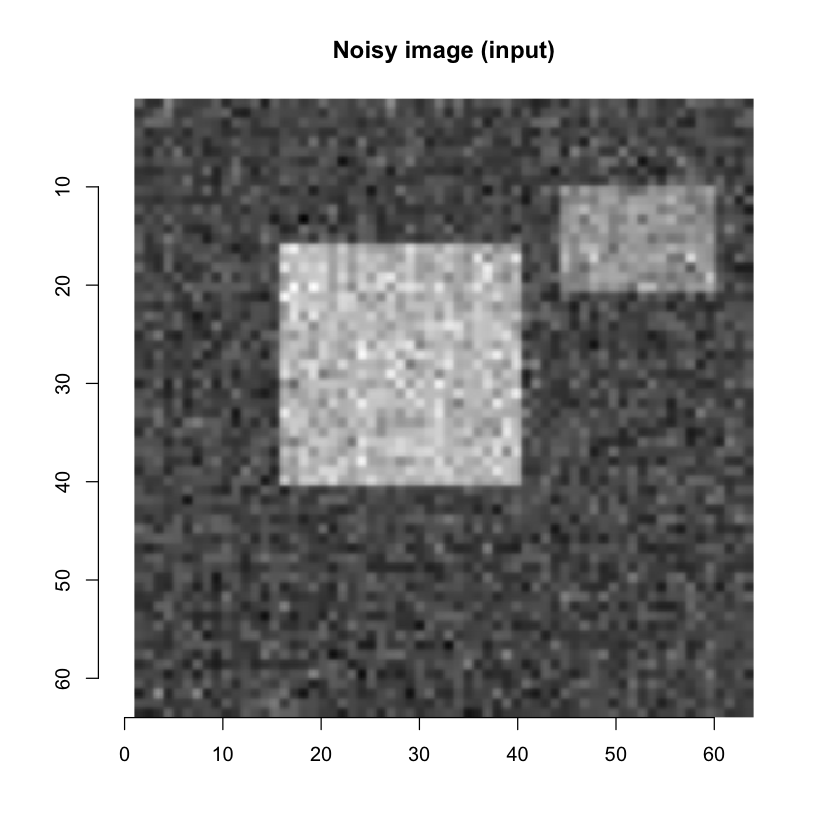

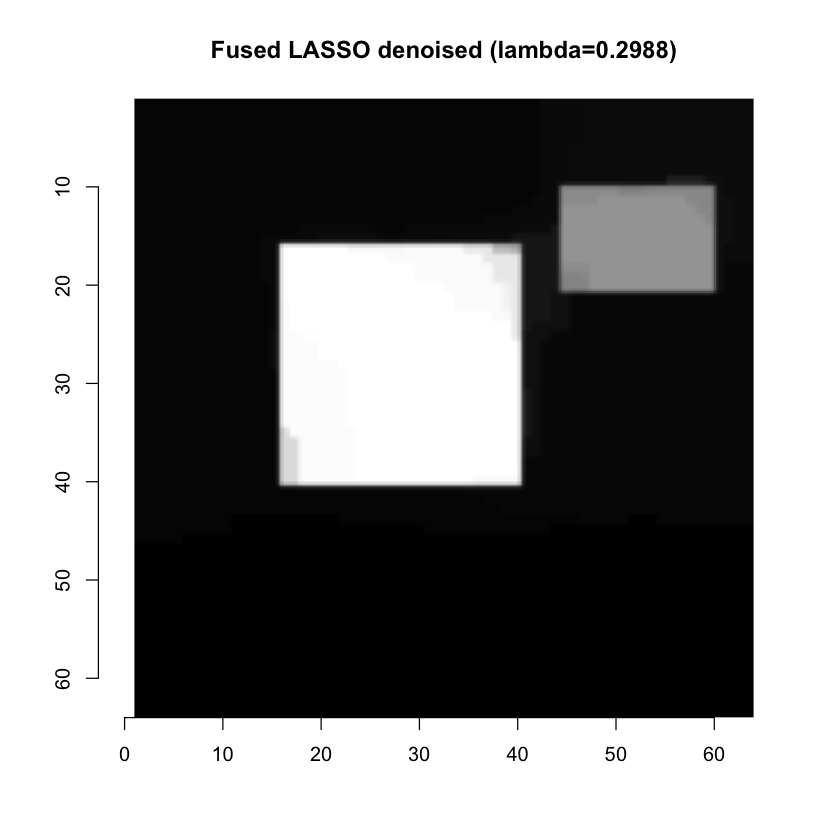

In [5]:
# -------------------- Fused LASSO on 2D image using genlasso -------
# We will use genlasso::fusedlasso with a difference matrix D constructed for 2D.
# This solves: minimize 0.5||y - x||_2^2 + lambda ||D x||_1

build_diff_ops_sparse <- function(nr, nc) {
  if (!requireNamespace('Matrix', quietly = TRUE)) stop('Install package Matrix')
  library(Matrix)
  N <- nr * nc
  # horizontal differences
  rows_h <- c(); cols_h <- c(); vals_h <- c(); rcount <- 1
  for (i in 1:nr) {
    for (j in 1:(nc - 1)) {
      idx <- (j - 1) * nr + i
      idx2 <- j * nr + i
      rows_h <- c(rows_h, rcount, rcount)
      cols_h <- c(cols_h, idx, idx2)
      vals_h <- c(vals_h, -1, 1)
      rcount <- rcount + 1
    }
  }
  Dh <- sparseMatrix(i = rows_h, j = cols_h, x = vals_h, dims = c(nr * (nc - 1), N))
  # vertical differences
  rows_v <- c(); cols_v <- c(); vals_v <- c(); rcount <- 1
  for (j in 1:nc) {
    for (i in 1:(nr - 1)) {
      idx <- (j - 1) * nr + i
      idx2 <- (j - 1) * nr + i + 1
      rows_v <- c(rows_v, rcount, rcount)
      cols_v <- c(cols_v, idx, idx2)
      vals_v <- c(vals_v, -1, 1)
      rcount <- rcount + 1
    }
  }
  Dv <- sparseMatrix(i = rows_v, j = cols_v, x = vals_v, dims = c((nr - 1) * nc, N))
  D <- rbind(Dh, Dv)
  D
}

fused_lasso_genlasso <- function(y_image, lambda = 0, nlambda = 50) {
  if (!requireNamespace('genlasso', quietly = TRUE)) stop('Install package genlasso')
  library(genlasso)
  nr <- nrow(y_image); nc <- ncol(y_image); N <- nr * nc
  y_vec <- as.numeric(y_image)
  D <- build_diff_ops_sparse(nr, nc)
  # genlasso::fusedlasso accepts y and D (and optionally X)
  # We will compute solution path and let user pick lambda or pick by heuristic
  fit <- genlasso::fusedlasso(y = y_vec, D = D, minlam = 0)
  # fusedlasso returns path; if lambda provided, interpolate; else pick moderate index
  if (!is.null(lambda)) {
    # find index with closest lambda
    idx <- which.min(abs(fit$lambda - lambda))
  } else {
    # pick median lambda index (heuristic)
    idx <- ceiling(length(fit$lambda) / 3)
  }
  x_hat <- fit$beta[, idx]
  x_img <- matrix(x_hat, nrow = nr, ncol = nc)
  list(fit = fit, idx = idx, x = x_hat, x_img = x_img, lambda_used = fit$lambda[idx])
}

# -------------------- Image import helper -------------------------
import_image_gray <- function(path, target_dim = NULL) {
  if (!requireNamespace('imager', quietly = TRUE)) stop('Please install package imager')
  library(imager)
  img <- load.image(path)
  imgg <- grayscale(img)
  # resize if requested
  if (!is.null(target_dim)) imgg <- imager::imresize(imgg, size = target_dim)
  mat <- t(as.matrix(imgg))
  mat
}

# Example 4: Fused LASSO on simulated image + optional import
example_fused_lasso <- function(simulate = TRUE, img_path = NULL, nr = 64, nc = 64, lambda = 0) {
  if (simulate) {
    # synthetic piecewise constant image + noise
    img <- matrix(0, nr, nc)
    img[16:40, 16:40] <- 1
    img[10:20, 45:60] <- 0.7
    noisy <- img + matrix(rnorm(nr * nc, sd = 0.2), nr, nc)
    y <- noisy
  } else {
    if (is.null(img_path)) stop('Provide img_path when simulate = FALSE')
    y <- import_image_gray(img_path, target_dim = c(nr, nc))
  }
  res <- fused_lasso_genlasso(y, lambda = lambda)
  # display if imager available
  if (requireNamespace('imager', quietly = TRUE)) {
    library(imager)
    plot(as.cimg(t(y)), main = 'Noisy image (input)')
    plot(as.cimg(t(res$x_img)), main = sprintf('Fused LASSO denoised (lambda=%.4g)', res$lambda_used))
  }
  invisible(list(y = y, denoised = res$x_img, res = res))
}

model=example_fused_lasso(simulate = TRUE)